## Auto Encoder ~~~
- unsupervised learning 
- 데이터 특성 분석 및 추출, 입력 데이터 특징점 찾기
- 데이터 압축, 노이즈 제거 용도
- 부호화 / 복호화
- PCA(Principle component analysis)를 딥러닝 방식으로 확장
- NN을 이용하기 때문에 데이터 구성이 복잡하거나 대량의 데이터인 경우에 AE가 더 효과적

In [1]:
from keras import layers, models

Using TensorFlow backend.


In [2]:
class AE(models.Model):
    def __init__(self, x_nodes=784, z_dim=36):
        x_shape = (x_nodes,)
        x = layers.Input(shape=x_shape)
        z = layers.Dense(z_dim, activation='relu')(x)
        y = layers.Dense(x_nodes, activation='sigmoid')(z) # 흑/백 이미지의 특성을 반영하기 위해 sigmoid (회색이미지라면 선형 함수)
        
        super().__init__(x, y)
        
        # 요런 식으로 주요 레이어를 저장해두면 따로 떼어서 모델을 만들 수도 있다.
        self.x = x
        self.z = z
        self.z_dim = z_dim
        
        self.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
        self.summary()
    
    # 앞서 저장해 놓은 레이어를 이용해 부호화 / 복호화 모델을 별도로 만들 수 있다.
    def Encoder(self):
        return models.Model(self.x, self.z)
    
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape=z_shape)
        y_layer = self.layers[-1] # 기존에 정의 했던 layer의 출력 계층만 떼어올 수 
        y = y_layer(z)
        return models.Model(z, y)

### 데이터 준비
- 원소끼리 곱해주는 np.prod

In [3]:
from keras.datasets import mnist
import numpy as np
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
#X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
#X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


### 학습 효과 분석

In [4]:
from keraspp.skeras import plot_loss, plot_acc
import matplotlib.pyplot as plt

def show_ae(autoencoder):
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()
    
    encoded_imgs = encoder.predict(X_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    n = 10
    plt.figure(figsize=(20, 6)) # 전체 그림 크기를 지정해줘야 균형이 맞음 (지정 x시 하나의 이미지라고 가정)
    
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + n)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3,n, i + 1 + n + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()  

### 학습 및 성능 평가
- 1회 배치마다 256개 데이터 학습
- 참고: 예전에 validation_data=(X_test,X_test) 대신에 validation_split=0.2 옵션을 통해 20%를 성능 검증에 활용했었음

In [5]:
def main():
    x_nodes = 784
    z_dim = 10
    
    autoencoder = AE(x_nodes, z_dim)
    
    history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True, validation_data=(X_test, X_test))
    
    plot_acc(history)
    plt.show()
    
    plot_loss(history)
    plt.show()
    
    show_ae(autoencoder)
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               8624      
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.3927 - acc: 0.7358 - val_loss: 0.2762 - val_acc: 0.7928
Epoch 2/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.2722 - acc: 0.7957 - val_loss: 0.2669 - val_acc: 0.7961
Epoch 3/10
60000/60000 [==============================] - 2s 27us/step - loss:

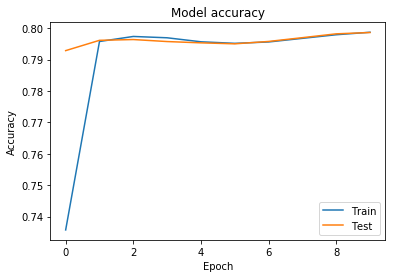

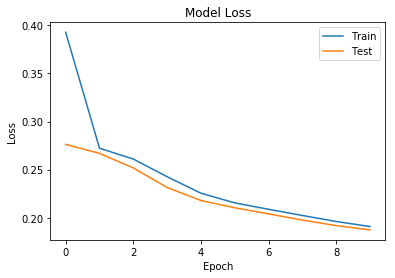

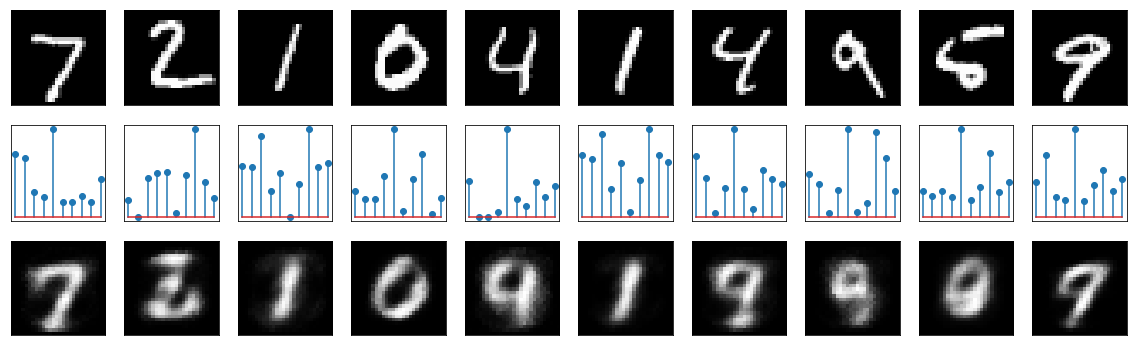

In [6]:
main()